In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
from scipy import stats
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221020'
}

In [3]:
q = '''
select exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from simulator_20221020.feed_actions
where toDate(time) between '2022-10-03' and '2022-10-09'
    and exp_group in (1, 2)
group by exp_group, user_id    
'''
df = ph.read_clickhouse(q, connection=connection)

In [4]:
#посмотрим на средние значения и распределение CTR в группах
df.query('exp_group == 1').ctr.mean(),df.query('exp_group == 2').ctr.mean()

(0.21560459841296287, 0.21441927347479375)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

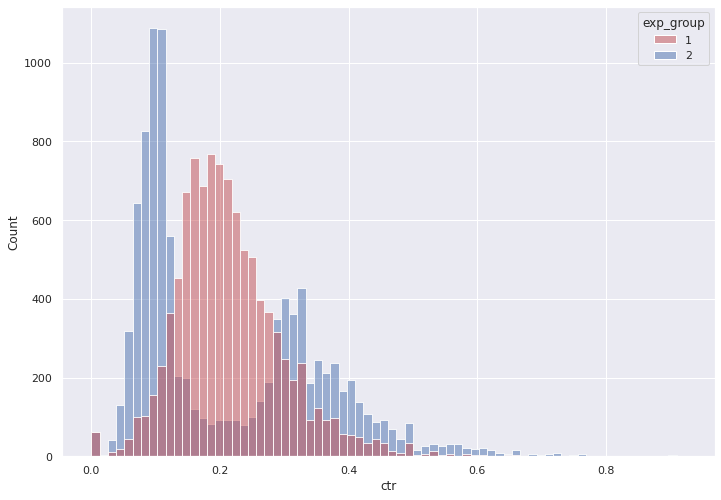

In [6]:
sns.histplot(data = df,
    x='ctr',
    hue='exp_group',
    palette = ['r', 'b'],
    alpha=0.5,
    kde=False)

Средние значения практически не отличаются, что нельзя сказать про распределения: контрольной группы - нормальное, а тестовой - бимодальное. Могу предположить, что в данной ситуации, когда распределения двух выборок кардинально различаются, следует выбрать Пуассоновский бутстреп, потому что он более устойчив к такого рода ситуациям, ведь при генерации подвыборок включается ЦПТ.

In [7]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

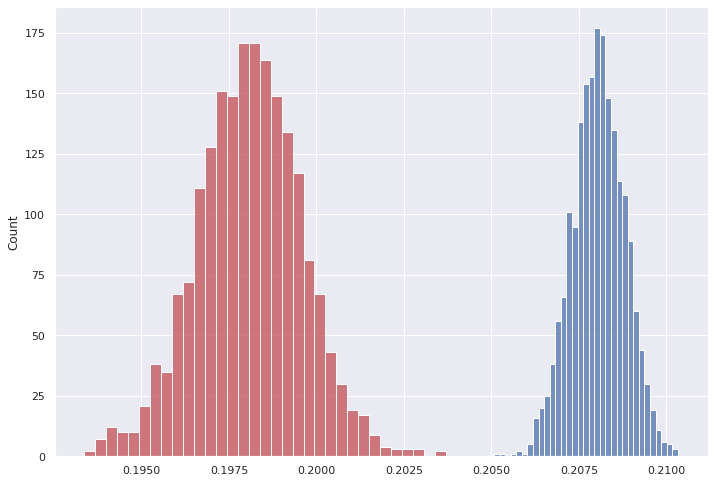

In [8]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1)
sns.histplot(ctr2, color = 'r')

<AxesSubplot:ylabel='Count'>

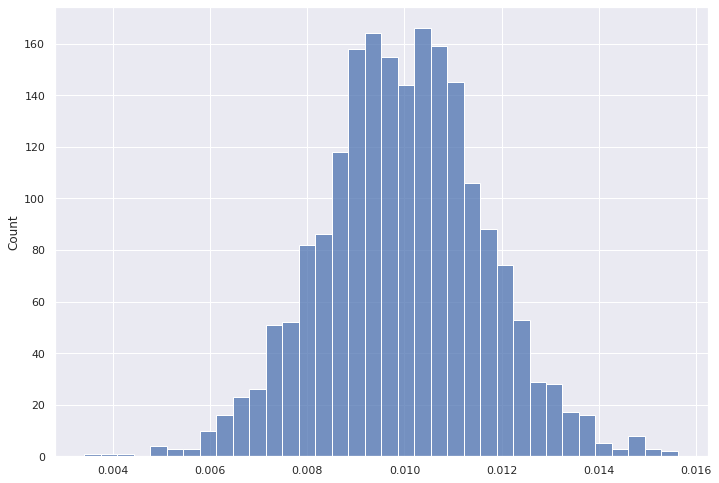

In [9]:
sns.histplot(ctr1 - ctr2)

Из графиков видно, что глобальные CTR не пересекаются. При этом CTR в контрольной группе выше.

Вывод: Исходя из рузельтатов проведенного АВ-теста моей рекомендацией будет не раскатывать данный алгоритм на всех новых пользователей. 
Могу предположить, что бимодальное распределение CTR наблюдается по следующим причинам:
-алгоритм некоректно сработал у определенной группы пользователей (например, у разных OS);
-алгоритм ошибочно определял посты "похожие на лайкнутые";
-алгоритм банально разделил пользователей на тех кому "понравилось" и наоборот.